# 1. 결정 트리 학습과 시각화

In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [3]:
# export_graphviz 메서드를 통해서 dot파일로 출력하여 훈련된 트리 모델을 시각화할 수 있다.

from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=image_path("iris_tree.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

conda install python-graphviz

dot -Tpng iris_tree.dot -o iris_tree.png

<img src='images/decision_trees/iris_tree1.png'>

# 2. 예측하기

Node의 gini 속성은 불순도 (impurity)를 측정함. 순수(gini=0)

#### 식 6-1. 지니 불순도
$ G_i = 1- \sum\limits _{k=1} ^n {p_{i,k}}^2 $

$ p_{i,k} $는 $i$번째 노드에 있는 훈련 샘플 중 클래스 $k$에 속한 샘플의 비율

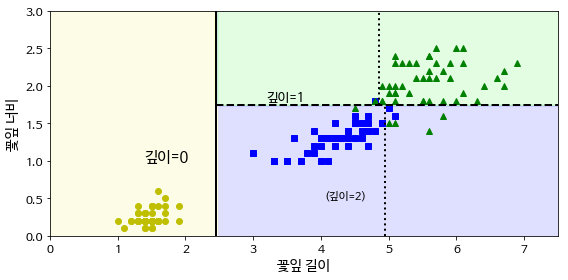

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("꽃잎 길이", fontsize=14)
        plt.ylabel("꽃잎 너비", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "깊이=0", fontsize=15)
plt.text(3.2, 1.80, "깊이=1", fontsize=13)
plt.text(4.05, 0.5, "(깊이=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

# 3. 클래스 확률 추정

In [8]:
# predict_proba() 메서드는 해당 샘플이 각 클래스로 예측될 확률을 알려줌

tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [9]:
tree_clf.predict([[5, 1.5]])

array([1])

# 4. CART 훈련 알고리즘

#### CART (Classification And Regression Tree) Algorithm
훈련 세트를 하나의 특성 $k$의 임곗값 $t_k$를 사용해 두 개의 서브셋으로 나눈다.    (가장 순수한 서브셋으로 나눌 수 있는 $\left( k, t_k \right)$짝을 찾는다.)

#### 식 6-2. 분류에 대한 CART 비용 함수
$ J\left( k, t_k \right) = \dfrac {m_{\mathrm{left}}} {m} G_{\mathrm{left}} + \dfrac {m_{\mathrm{right}}} {m} G_{\mathrm{right}} $ 

$ \begin{cases} 
    G_{\mathrm{left / right}} & \mbox{left / right subset's impurity} \\
    m_{\mathrm{left / right}} & \mbox{left / right subset's sample number}
    \end{cases}$
    
위 알고리즘은 max_depth까지 가거나 불순도를 줄이는 분할을 찾을 수 없을 때까지 재귀 반복된다.

#### 탐욕적 알고리즘 (Greedy Algorithm)
루트 노드에서부터 최적의 분할을 찾고 각 단계에서 반복한다.

현 단계의 분할이 몇 단계 뒤 가장 낮은 불순도로 이어질지 아닐지는 고려하지 않는다.

따라서 탐욕적 알고리즘은 그 순간에 대해서는 지역적으로 최선이지만, 그 선택들을 수집한 최종 해가 전역적으로 최적해라는 보장은 없다. (근사치일 뿐)

https://ko.wikipedia.org/wiki/%ED%83%90%EC%9A%95_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98

# 5. 계산 복잡도

$n \times m$ 데이터셋에 대하여
- 탐색 : $O\left( \log_2(m) \right)$
- 훈련 : $O\left( n \times m\log(m) \right)$

# 6. 지니 불순도 & 엔트로피

#### 식 6-1. 지니 불순도
$ G_i = 1- \sum\limits _{k=1} ^n {p_{i,k}}^2 $

- $ p_{i,k} $는 $i$번째 노드에 있는 훈련 샘플 중 클래스 $k$에 속한 샘플의 비율

#### 식 6-3. 엔트로피
$ H_i = \underset{p_{i,k} \ne 0} {- \sum\limits _{k=1} ^n p_{i,k}} \log _2 (p_{i,k}) $

- 엔트로피가 0 (순수)

##### Example

samples = 54

values = [0, 49, 5]인 노드의 엔트로피는

$ -\dfrac{49}{54} \log_2 \left( \dfrac{49}{54} \right)  -\dfrac{5}{54} \log_2 \left( \dfrac{5}{54} \right) \approx 0.445 $

지니계수가 계산이 조금 더 빠르기 때문에 일반적으로 선호된다.

하지만 지니계수는 가장 빈도가 높은 클래스를 한쪽 가지로 고립시키는 경향이 있기 때문에, balanced tree를 만들고 싶을 때는 엔트로피를 사용하는 것이 좋다.

# 7. 규제 매개변수

#### 비파라미터 모델 (Nonparameter Model)
훈련되기 전에 파라미터 수가 결정되지 않는 모델

- DT는 훈련 데이터에 대한 제약사항이 거의 없어서
- 제한을 두지 않으면 (규제, 자유도 제한) 과적합되기 쉽다.

#### 트리에서의 규제 매개변수들
- max_depth
- max_leaf_nodes
- max_features
- min_samples_split
- min_samples_leaf
- min_weight_fraction_leaf
- min_impurity_decreases
- min_impurity_split

max를 감소시키거나 min을 증가시키면 규제 증가

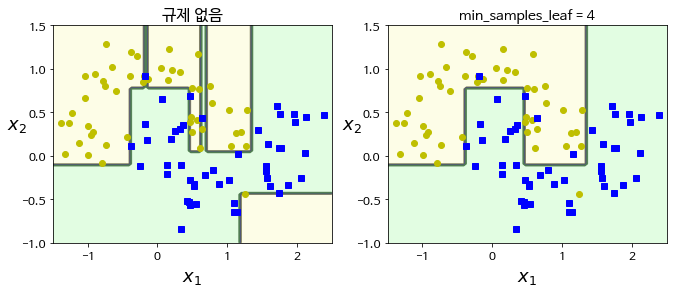

In [10]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("규제 없음", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

# save_fig("min_samples_leaf_plot")
plt.show()

#### 가지치기 (Pruning) Algorithm
제한없이 트리를 훈련시킨 후 불필요한 노드를 제거하는 알고리즘

순도를 높이는 것이 
##### 통계적으로 유의미하지 않다면
리프 노드 바로 위의 노드는 불필요하므로 가지치기를 실행한다.

# 8. 회귀

In [11]:
# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [12]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

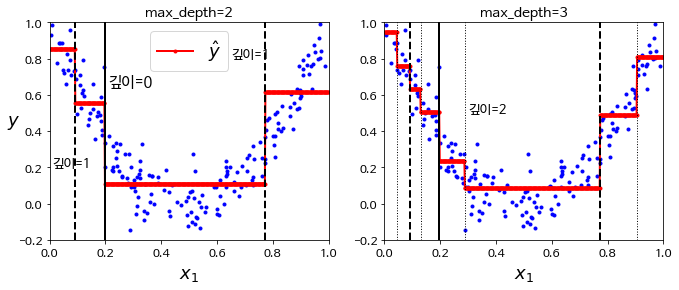

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)

for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "깊이=0", fontsize=15)
plt.text(0.01, 0.2, "깊이=1", fontsize=13)
plt.text(0.65, 0.8, "깊이=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "깊이=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

# save_fig("tree_regression_plot")
plt.show()

In [14]:
export_graphviz(
        tree_reg1,
        out_file=image_path("regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

<img src='images/decision_trees/regression_tree.png'>

#### 식 6-4. 회귀를 위한 CART 비용 함수
$ J\left( k, t_k \right) = \dfrac {m_{\mathrm{left}}} {m} \mathrm{MSE}_{\mathrm{left}} + \dfrac {m_{\mathrm{right}}} {m} \mathrm{MSE}_{\mathrm{right}} $ 

$ \begin{cases} 
    \mathrm{MSE}_{\mathrm{node}} = \sum\limits _{i \in {\mathrm{node}}} \left( \hat y_{\mathrm{node}} - y^{(i)} \right) ^2 & \\
    \hat y _{\mathrm{node}} = \dfrac {1} {m_{\mathrm{node}}} \sum\limits _{i \in \mathrm{node}} y^{(i)} & 
    \end{cases}$

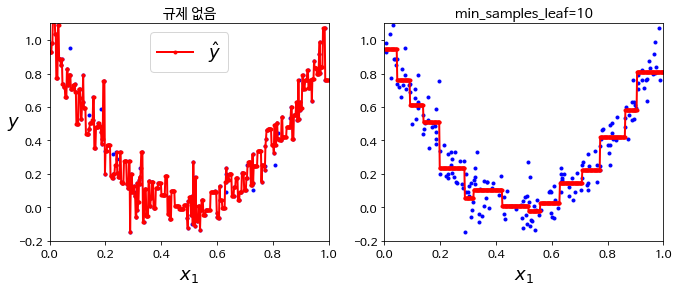

In [15]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("규제 없음", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

# save_fig("tree_regression_regularization_plot")
plt.show()

# 9. 불안정성

#### 데이터의 회전에 민감함
$\because $ tree는 계단 모양으로 결정경계를 생성하기 때문에 (축에 수직)

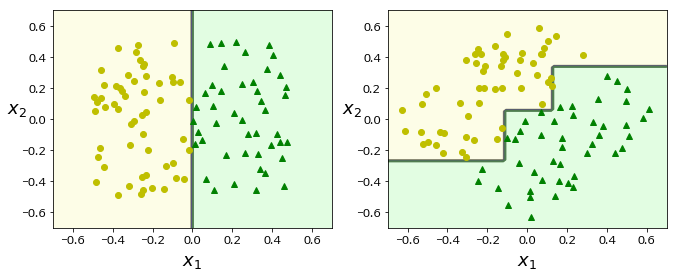

In [16]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

# save_fig("sensitivity_to_rotation_plot")
plt.show()

#### 데이터의 작은 변화에도 민감함

In [19]:
X = iris.data[:, 2:] # petal length and width
y = iris.target

In [20]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # 가장 너비가 큰 Iris-Versicolor

array([[4.8, 1.8]])

In [21]:
# 훈련 세트에서 Iris-Versicolor를 제거

not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=40,
            splitter='best')

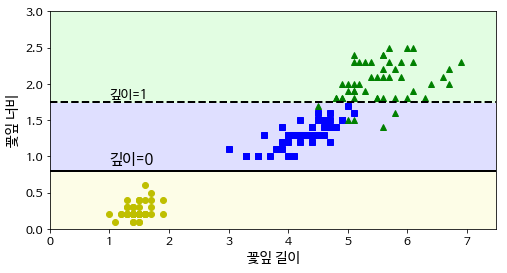

In [22]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "깊이=0", fontsize=15)
plt.text(1.0, 1.80, "깊이=1", fontsize=13)

# save_fig("decision_tree_instability_plot")
plt.show()